## Стэкинг 

Пример стэкинга нескольких классификаторов

In [2]:
# отключение ворнингов
import warnings
warnings.filterwarnings('ignore')

# импорт библиотек
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, Ridge
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import (train_test_split, cross_val_score, cross_val_predict, learning_curve,
                                     validation_curve, StratifiedKFold, RandomizedSearchCV, GridSearchCV)
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, plot_roc_curve
from tqdm import tqdm

In [3]:
# настройки отображения строк и столбцов в пандас
pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', 50)

# настройка размеров графиков
%pylab inline
pylab.rcParams['figure.figsize'] = (12, 8)

# настройка стиля графиков
plt.style.use('ggplot')

Populating the interactive namespace from numpy and matplotlib


In [4]:
# читаем данные
df = pd.read_csv('./data/Telco-Customer-Churn.csv')

# выведу для проверки
df.head(5)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [5]:
# в данных есть странные пропуски- пробел, удалю их

rows_to_drop = df[df['TotalCharges']==" "].index
df.drop(rows_to_drop, axis=0, inplace=True)

In [6]:
# выведу долю пропусков по столбцам, если есть

def missing_values(data):
    """
    Возвращает колонки с пропусками(если есть):
    - общее число пропущенных значений
    - доля пропусков
    """
    missing = pd.DataFrame(df.isnull().sum())
    missing['% of Total Values'] = 100 * df.isnull().sum() / len(df)
    missing.rename(columns = {0 : 'Missing Values'}, inplace=True)
    missing.sort_values(by='% of Total Values', ascending=False, inplace=True)
    missing = missing[missing['Missing Values']>0]
    
    if missing.shape[0] == 0:
        print('В данных нет пропусков!')
    else:
        return missing

missing_values(df)

В данных нет пропусков!


## Подготовка данных

In [7]:
# закодирую целевую перменную
df['Churn'] = df['Churn'].map({'No': 0, 'Yes': 1})

# приведу признак total charges к числовому типу
df['TotalCharges'] = df['TotalCharges'].astype('float')

# удалю идентификатор клиента
df.drop('customerID', axis=1, inplace=True)

# категориальные переменные
cat_features = df.columns[df.dtypes == 'object']

# OHE для категориальных переменных
df = pd.get_dummies(df, columns=cat_features)

print(f'Размерность датасета с OHE: {df.shape}')

Размерность датасета с OHE: (7032, 46)


In [8]:
# отделю таргет и признаки
X = df.drop('Churn', axis=1)
y = df['Churn']

# воспроизводимость
rs = np.random.seed(0)
    
# разобью данные на трейн и тест
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.4, random_state=rs, stratify=y)
       
print('Доля положительных примеров в трейне: {:.4f}'.format(np.mean(y_train)), end='\n\n')
print('Доля положительных примеров в тесте: {:.4f}'.format(np.mean(y_test)))

Доля положительных примеров в трейне: 0.2657

Доля положительных примеров в тесте: 0.2659


In [9]:
# стандартизация данных
scaler = StandardScaler()
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

## Обучение моделей

In [10]:
def cross_validation(classifier, X_train, y_train, cv=3, scoring='accuracy'):
    # название модели для красивого вывода
    clf_name = str(classifier)
    try:
        clf_name = clf_name[:clf_name.index('(')]
    except ValueError:
        pass
    cv_scores = cross_val_score(classifier, X_train, y_train, scoring=scoring, cv=cv)
    print('Среднее значение \033[1m{}\033[0m для {} на валидации: \033[1m{:.4f}\033[0m'.format(
        scoring, clf_name, np.mean(cv_scores)))
    
def fit_evaluate(classifier, X_train, X_test, y_train, y_test, metric=accuracy_score):
    # название модели для красивого вывода
    clf_name = str(classifier)
    try:
        clf_name = clf_name[:clf_name.index('(')]
    except ValueError:
        pass
    
    # название метрики 
    metric_name = str(metric)
    metric_name = metric_name[metric_name.index(' ')+1:metric_name.index(' at')]
    classifier.fit(X_train, y_train)
    predictions = classifier.predict_proba(X_test)[:, 1]
    print('Среднее значение \033[1m{}\033[0m для {} на отложенной выборке: \033[1m{:.4f}\033[0m'.format(
        metric_name, clf_name, metric(y_test, predictions)))

In [11]:
# кросс валидация
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=rs)

# случайный лес 

rf = RandomForestClassifier(random_state=rs)

cross_validation(rf, X_train, y_train, cv=skf, scoring='roc_auc')
fit_evaluate(rf, X_train, X_test, y_train, y_test, metric=roc_auc_score)

Среднее значение roc_auc для RandomForestClassifier на валидации: 0.8193
Среднее значение roc_auc_score для RandomForestClassifier на отложенной выборке: 0.8275


In [12]:
# градиентный бустинг

lgbm = LGBMClassifier(random_state=rs)

cross_validation(lgbm, X_train, y_train, cv=skf, scoring='roc_auc')
fit_evaluate(lgbm, X_train, X_test, y_train, y_test, metric=roc_auc_score)

Среднее значение roc_auc для LGBMClassifier на валидации: 0.8292
Среднее значение roc_auc_score для LGBMClassifier на отложенной выборке: 0.8332


In [13]:
# логистическая регрессия

logit = LogisticRegression(random_state=rs)

cross_validation(logit, X_train, y_train, cv=skf, scoring='roc_auc')
fit_evaluate(logit, X_train, X_test, y_train, y_test, metric=roc_auc_score)

Среднее значение roc_auc для LogisticRegression на валидации: 0.8453
Среднее значение roc_auc_score для LogisticRegression на отложенной выборке: 0.8438


## Подбор гиперпараметров для случайного леса

Подбирать буду стандартный набор признаков, характерный для моделей, основанных на деревьях решений:

- количество деревьев - n_estimators
- максимальная глубина дерева - max_depth
- минимальное число элементов в листе - min_samples_leaf
- максимальное количество листьев в дереве max_leaf_nodes
- минимальное число объектов для разбиения min_samples_split
- вес класса - class_weight

In [18]:
%%time

# пройду по широкой сетке параметров
rf_params = {
    'n_estimators': np.linspace(10, 2000, 1000, dtype=int),
    'max_depth': np.arange(1,20),
    'min_samples_leaf': np.arange(1, 100),
    'max_leaf_nodes': [10, 50, 100, 150, 200, 300, 500, 750, 1000],
    'min_samples_split': np.arange(5, 50),
    'class_weight': ['balanced', None],
}


rf_grid = RandomizedSearchCV(
    estimator=RandomForestClassifier(random_state=rs),
    scoring='roc_auc',
    param_distributions=rf_params,
    cv=skf,
    n_jobs=-1,
    random_state=rs,
    n_iter=1000
)

rf_grid.fit(X_train, y_train)
final_rf = rf_grid.best_estimator_

fit_evaluate(final_rf, X_train, X_test,
             y_train, y_test, metric=roc_auc_score)

Среднее значение roc_auc_score для RandomForestClassifier на отложенной выборке: 0.8469
CPU times: user 36.6 s, sys: 1.86 s, total: 38.5 s
Wall time: 14min 43s


In [19]:
# выведу classification report для RF

prediction_labels = final_rf.predict(X_test)

print(classification_report(y_test, prediction_labels))

              precision    recall  f1-score   support

           0       0.83      0.91      0.87      2065
           1       0.67      0.49      0.56       748

    accuracy                           0.80      2813
   macro avg       0.75      0.70      0.72      2813
weighted avg       0.79      0.80      0.79      2813



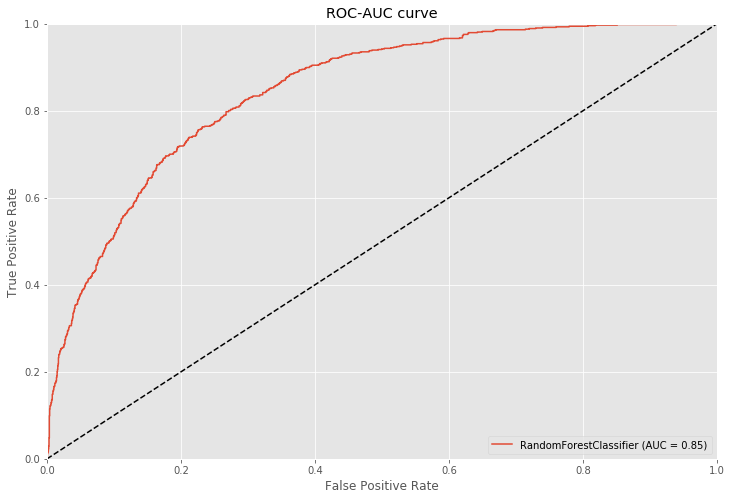

In [20]:
# roc кривая для RF

plot_roc_curve(final_rf, X_test, y_test)
plt.title('ROC-AUC curve')
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'k--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show();

## Подбор гиперпараметров для градиентного бустинга

Подбирать буду тот же набор признаков, что и для RF, добавлю только learning_rate:

- количество деревьев - n_estimators
- максимальная глубина дерева - max_depth
- минимальное число элементов в листе - min_data_in_leaf
- максимальное количество листьев в дереве num_leaves
- минимальное число объектов для разбиения min_child_samples
- вес класса - class_weight
- learning_rate


Подбирать буду с помощью RandomizedSearchCV

In [25]:
%%time

# пройду по широкой сетке параметров
lgbm_params = {
    'n_estimators': np.linspace(10, 2000, 1000, dtype=int),
    'max_depth': np.arange(1,20),
    'min_data_in_leaf': np.arange(1, 100),
    'num_leaves': [10, 50, 100, 150, 200, 300, 500, 750, 1000],
    'min_child_samples': np.arange(5, 50),
    'class_weight': ['balanced', None],
    'learning_rate':np.arange(0.1, 1),
    'bagging_fraction': np.arange(0.5, 1, 0.1),
    'bagging_freq': np.arange(1, 5),
    'feature_fraction': np.arange(0.5, 1, 0.1)
}


lgbm_grid = RandomizedSearchCV(
    estimator=LGBMClassifier(metric='roc_auc', random_state=rs),
    scoring='roc_auc',
    param_distributions=lgbm_params,
    cv=skf,
    n_jobs=-1,
    random_state=rs,
    n_iter=2000
)

lgbm_grid.fit(X_train, y_train)
final_lgbm = lgbm_grid.best_estimator_

fit_evaluate(final_lgbm, X_train, X_test,
             y_train, y_test, metric=roc_auc_score)

Среднее значение roc_auc_score для LGBMClassifier на отложенной выборке: 0.8484
CPU times: user 1min 14s, sys: 6 s, total: 1min 20s
Wall time: 17min 22s


In [26]:
# выведу classification report для LGBM

prediction_labels = final_lgbm.predict(X_test)

print(classification_report(y_test, prediction_labels))

              precision    recall  f1-score   support

           0       0.91      0.72      0.81      2065
           1       0.51      0.81      0.63       748

    accuracy                           0.75      2813
   macro avg       0.71      0.77      0.72      2813
weighted avg       0.81      0.75      0.76      2813



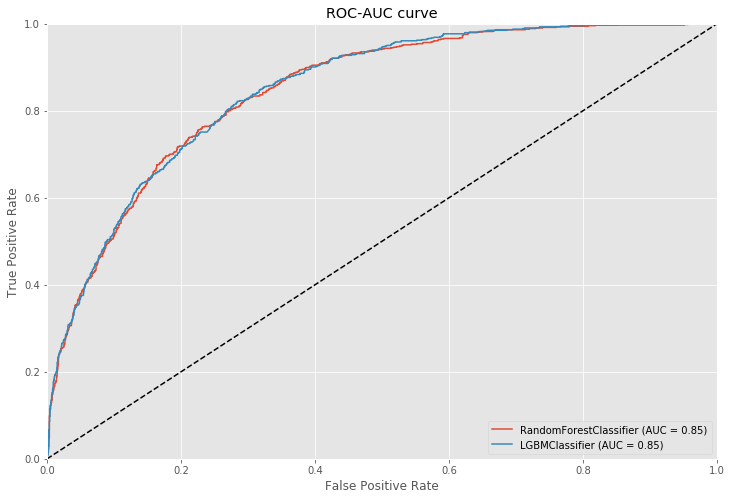

In [27]:
# roc кривая для lgbm и RF

rf_auc = plot_roc_curve(final_rf, X_test, y_test)
plot_roc_curve(final_lgbm, X_test, y_test, ax=rf_auc.ax_)
plt.title('ROC-AUC curve')
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'k--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show();

## Подбор гиперпараметров для логистической регрессии

Буду подбирать параметры регуляризации:
- регуляризатор l1 или l2 норма
- C- 1/коэффициент регуляризации

In [28]:
logit_params = dict(penalty=['l1', 'l2'],
                    C=np.logspace(-2, 0, 200)
                )

logit_cv = GridSearchCV(estimator=LogisticRegression(random_state=rs),
                        param_grid=logit_params, cv=skf, n_jobs=-1, verbose=False)

logit_cv.fit(X_train, y_train)
final_logit = logit_cv.best_estimator_

preds = final_logit.predict_proba(X_test)[:, 1]
score = roc_auc_score(y_test, preds)
print(f'ROC-AUC для Logit {score:.4f}', end='\n\n')
print(classification_report(y_test, np.where(preds>0.5, 1, 0)))

ROC-AUC для Logit 0.8438

              precision    recall  f1-score   support

           0       0.84      0.89      0.87      2065
           1       0.65      0.54      0.59       748

    accuracy                           0.80      2813
   macro avg       0.74      0.72      0.73      2813
weighted avg       0.79      0.80      0.79      2813



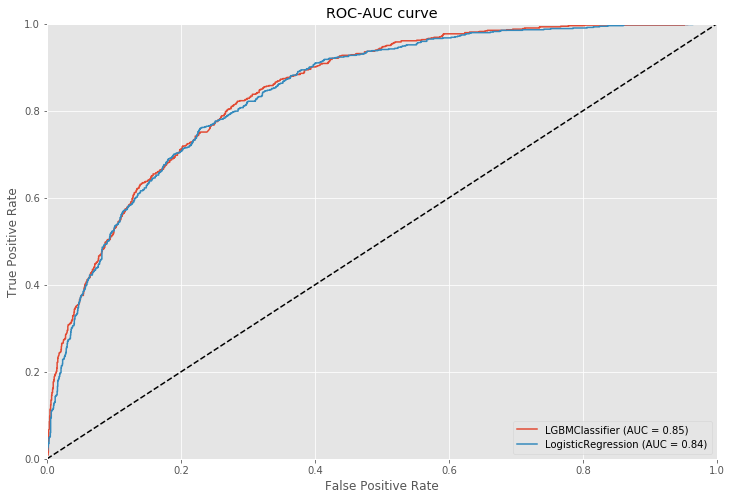

In [33]:
# roc кривая для logit

lgbm_auc = plot_roc_curve(final_lgbm, X_test, y_test)

plot_roc_curve(final_logit, X_test, y_test, ax=lgbm_auc.ax_)
plt.title('ROC-AUC curve')
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'k--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show();

## Кривые обучения и валидации

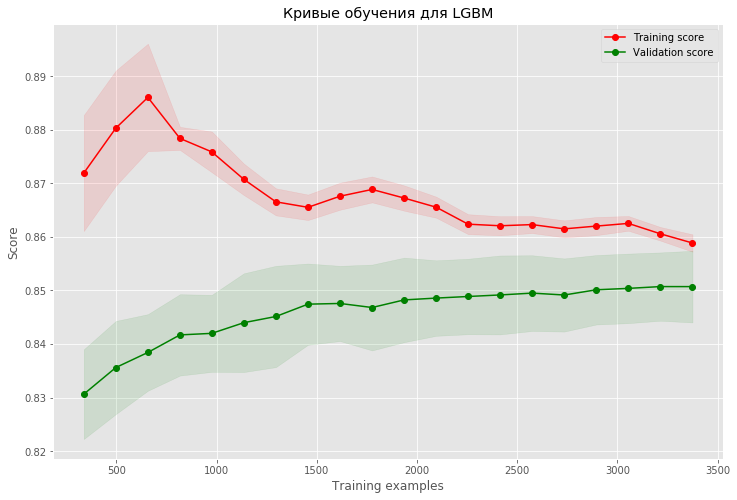

In [34]:
# построю кривые обучения

def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 20)):
    
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel('Training examples')
    plt.ylabel('Score')
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, scoring='roc_auc')
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color='r',
             label='Training score')
    plt.plot(train_sizes, test_scores_mean, 'o-', color='g',
             label='Validation score')

    plt.legend(loc="best")
    return plt


plot_learning_curve(final_lgbm, 'Кривые обучения для LGBM', X_train, y_train, cv=5, n_jobs=-1);

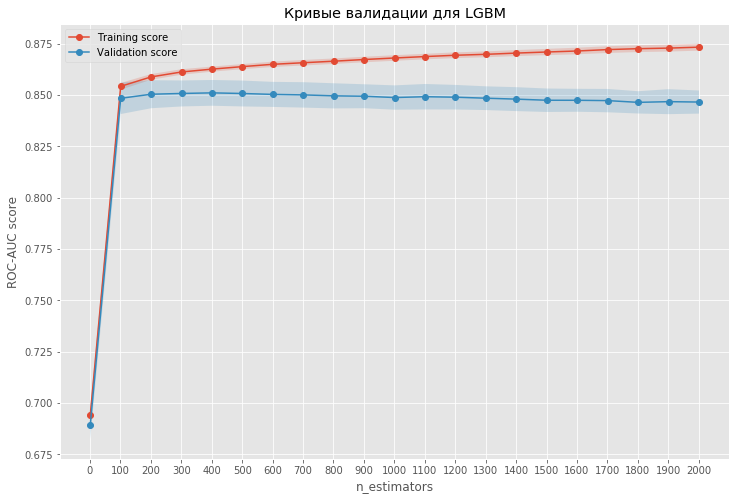

In [35]:
# построю кривые валидации

def plot_with_err(param, data, **kwargs):
    """
    Строит кривые валидации
    """
    mu, std = data.mean(1), data.std(1)
    lines = plt.plot(param, mu, 'o-', **kwargs)
    plt.fill_between(param, mu - std, mu + std, edgecolor='none',
                     facecolor=lines[0].get_color(), alpha=0.2)
    
    
n_estimators = np.arange(1, 2050, 100)
val_train, val_test = validation_curve(final_lgbm, X_train, y_train,
                                       'n_estimators', n_estimators, cv=5,
                                        scoring='roc_auc')


plot_with_err(n_estimators, val_train, label='Training score')
plot_with_err(n_estimators, val_test, label='Validation score')
plt.xlabel('n_estimators'); plt.ylabel('ROC-AUC score')
plt.xticks(np.arange(0, 2050, 100))
plt.title('Кривые валидации для LGBM')
plt.legend();

## Отбор признаков

Отбор признаков простым перебором.

In [37]:
def feature_selector(estimator, X, y, cv=3, scoring='accuracy'):
    """
    Simple feature selector
    :param estimator: sklearn like eatimator
    :param X: features, pandas DataFrame
    :param y: labels, pandas Series
    """
    # название модели для красивого вывода
    estimator_name = str(estimator)
    try:
        estimator_name = estimator_name[:estimator_name.index('(')]
    except ValueError:
        pass
    
    # формируем список признаков
    features = list(X.columns)
    
    # сохраняем результат на всех фичах
    best_score = np.mean(cross_val_score(estimator, X, y, cv=cv, scoring=scoring))
    best_features = features.copy()
    
    for column in tqdm(features):
        if column in best_features:
            best_features.remove(column)
            score = np.mean(cross_val_score(estimator, X[best_features], y, cv=cv, scoring=scoring))
            # если результат ухудшился, возвращаем признак в список
            if score < best_score:
                best_features.append(column)
            else:
                best_score = score
    print(f'Best score of {estimator_name} is {best_score:.4f}')
    
    # обучаем классификатор на полученных фичах
    estimator.fit(X[best_features], y)
    
    return estimator, best_features

In [38]:
# приведем признаки обратно к пандас для удобства работы с признаками
X_train = pd.DataFrame(X_train, columns=X.columns, index=y_train.index)
X_test = pd.DataFrame(X_test, columns=X.columns, index=y_test.index)

# получаем обученные модели и их лучшие признаки
best_gb, gb_best_features = feature_selector(final_lgbm, X_train, y_train, cv=5, scoring='roc_auc')
best_rf, rf_best_features = feature_selector(final_rf, X_train, y_train, cv=5, scoring='roc_auc')
best_logit, logit_best_features = feature_selector(final_logit, X_train, y_train, cv=5, scoring='roc_auc')

100%|██████████| 45/45 [00:34<00:00,  1.31it/s]


Best score of LGBMClassifier is 0.8512


100%|██████████| 45/45 [06:56<00:00,  9.26s/it]


Best score of RandomForestClassifier is 0.8461


100%|██████████| 45/45 [00:08<00:00,  5.49it/s]

Best score of LogisticRegression is 0.8452


In [39]:
# получаем результат по отложенной выборке

base_models = [best_gb, best_rf, best_logit]
base_features = [gb_best_features, rf_best_features, logit_best_features]

for idx, classifier in enumerate(base_models):
    clf_name = str(classifier)
    try:
        clf_name = clf_name[:clf_name.index('(')]
    except ValueError:
        pass
    
    pred = classifier.predict_proba(X_test[base_features[idx]])[:, 1]
    print(f'ROC-AUC of {clf_name} is {roc_auc_score(y_test, pred):.4f}')

ROC-AUC of LGBMClassifier is 0.8477
ROC-AUC of RandomForestClassifier is 0.8470
ROC-AUC of LogisticRegression is 0.8441


## Стэкинг моделей

In [40]:
class Stacking(BaseEstimator, ClassifierMixin):
    def __init__(self, models, meta_algorithm):
        self.models = models
        self.meta_algorithm = meta_algorithm
        self.features = [None for i in range(len(models))]
        
    def fit(self, X, y, features=None, cv=5, scoring='accuracy', random_state=None):
        """
        Fit base algotithms on training data and meta-algotithm on validation data.
        :param X_train: train features, pandas DataFrame
        :param X_valid: validation features, pandas DataFrame
        :param y_train: train labels, pandas Series
        :param y_valid: validation labels, pandas Series
        :param cv: cross-validation folds, int
        :param scoring : scoring metric, str
        :param random_state: random state
        """
        # списки признаков
        if features is None:
            self.features = [list(X.columns) for _ in range(len(self.models))]
        else:
            self.features = features
        
        # матрица метапризнаков
        self.meta_features = 0.001*np.random.randn(X.shape[0], len(self.models))
        
        for idx, clf in enumerate(self.models):
            # oob-ответы базовых алгоритмов
            self.meta_features[:, idx] += cross_val_predict(clf, X[self.features[idx]], y, cv=cv,
                                                   n_jobs=-1, method='predict_proba')[:, 1]
            # обучаем базовый алгоритм
            clf.fit(X[self.features[idx]], y)
        # обучаем метаалгоритм на ответах базовых
        self.meta_algorithm.fit(self.meta_features, y )
        return self
    
    def predict(self, X):
        """
        Makes predictions for StackingClassifier
        :param X: test features, pandas DataFrame
        """
        # матрица метапризнаков
        x_meta = np.zeros((X.shape[0], len(self.models)))
        
        # заполняем матрицу метапризнаков
        for idx, clf in enumerate(self.models):
                x_meta[:, idx] = clf.predict_proba(X[self.features[idx]])[:, 1]
        
        predictions = self.meta_algorithm.predict(x_meta)
        return predictions

In [41]:
st = Stacking(models=[final_lgbm, final_rf, final_logit],
              meta_algorithm=Ridge(random_state=rs))

st_clf = st.fit(X_train, y_train,
                features=None,
                cv=skf, scoring='roc_auc', random_state=rs)

preds_st = st_clf.predict(X_test)
print(f'Stacking ROC-AUC is {roc_auc_score(y_test, preds_st):.4f}')

Stacking ROC-AUC is 0.8484


In [42]:
st = Stacking(models=base_models,
              meta_algorithm=Ridge(random_state=rs))

st_clf = st.fit(X_train, y_train,
                features=base_features,
                cv=skf, scoring='roc_auc', random_state=rs)

preds_st = st_clf.predict(X_test)
print(f'Stacking ROC-AUC is {roc_auc_score(y_test, preds_st):.4f}')

Stacking ROC-AUC is 0.8488
